In [1]:
import pandas as pd
import numpy as np
import math
#import matplotlib as plt
import matplotlib.pyplot as plt

def Y_a_b(genes, a, b):
    return np.mean(genes[a:b])

def C_a_b(genes, a, b):
    mean = Y_a_b(genes, a, b+1)
    return sum( (np.array(genes[a:b+1]) - mean) ** 2 )

def determine_h(P, i, j, genes):
  
  N = len(genes)
  
  if (i == 0 and j > 0):
    return Y_a_b(genes, P[i][j], P[i+1][j]) - Y_a_b(genes, 0, P[i][j]);
  elif (i == j and j > 0):
    return Y_a_b(genes, P[i][j], N) - Y_a_b(genes, P[i-1][j], P[i][j]);
  elif (i == 0 and j == 0):
    return Y_a_b(genes, P[i][j], N) - Y_a_b(genes, 0, P[i][j]);
  else:
    return Y_a_b(genes, P[i][j], P[i+1][j]) - Y_a_b(genes, P[i-1][j], P[i][j]);

def BASC_A(gene):
    gene_og = gene
    gene = np.sort(gene)
    N = len(gene)

    cost_matrix = [[0 for _ in range(N - 1)] for _ in range(N)]
    ind_matrix = [[0 for _ in range(N - 2)] for _ in range(N - 1)]
    P = [[0 for _ in range(N - 2)] for _ in range(N - 2)]

    # Step 1: Compute a Series of Step Function

    # initialization C_i_(0) = c_i_N
    # calculate first cost matrix column with no intermidiate break points
    for i in range(N):
        cost_matrix[i][0] = C_a_b(gene, i, N)

    # Algorithm 1: Calculate optimal step functions
    for j in range(N-2):
      
      for i in range(N-j-1):
        min_value = math.inf
        min_index = math.inf

        for d in range(N-j-1):
          
          if(i <= d):
            curr_value = C_a_b(gene, i, d) + cost_matrix[d+1][j]
          
          if(curr_value < min_value):
            min_value = curr_value
            min_index = d

        cost_matrix[i][j+1] = min_value
        ind_matrix[i][j] = min_index + 1

    #  Algorithm 2: Compute the break points of all optimal step functions
    for j in range(N-2):
      
      z = j
      
      P[0][j] = ind_matrix[0][z]
    
      if(j > 0):
        z = z - 1
        for i in range(1, j+1):
          
          P[i][j] = ind_matrix[P[i-1][j]][z]
          
          z = z - 1

    # Step 2: Find Strongest Discontinuity in Each Step Function
    v = [0] * (N-2)

    for j in range(N-2):
      
      max_value = -math.inf
      
      max_index = j
      
      for i in range(j+1):
        h = determine_h(P, i, j, gene)
        z = (gene[P[i][j]] + gene[P[i][j]-1]) / 2
        e = sum( (np.array(gene) - z) ** 2 )
        q_score = h / e
        if(q_score > max_value):
          
          max_value = q_score
          
          max_index = i

      
      v[j] = P[max_index][j]

    # Step 3: Estimate Location and Variation of the Strongest Discontinuities
    thr = (gene[round(np.median(v))-1] + gene[round(np.median(v))]) / 2

    return thr, P


In [2]:
from sklearn.cluster import KMeans

def K_Means(genes):
    data = np.array(genes).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, n_init='auto')
    kmeans.fit(data)
    c=kmeans.labels_
    genes = np.array(genes)
    groupOne = genes[c==1]
    groupZero = genes[c==0]
    
    thr1 = np.mean(groupOne)
    thr2 = np.mean(groupZero)
    
    thr = (thr1 + thr2) / 2

    return thr

In [3]:
def getSSTOT(x, n, xmean):
    m = 0
    for i in range(n):
        m = m + (x[i] - xmean)**2
    return m


def onestep(x):
    
    n = len(x)
    #step = 0
    xmean = np.mean(x)
    SSTOT = getSSTOT(x, n, xmean)
    
    SSEmin = SSTOT
    
    for i in range(n-1):
        leftMean = np.mean(x[0:i+1])
    
        rightMean = np.mean(x[i+1:n])
        
        SSE = 0
        
        for j in range(n):
            if j < i+1:
                SSE = SSE + (x[j] - leftMean)**2
            else:
                SSE = SSE + (x[j] - rightMean)**2
                    
        
        if SSEmin > SSE:
            SSEmin = SSE
            #print("1:",SSEmin1)
                
            t = (leftMean + rightMean)/2
    
    
    
    return t

In [4]:
def shmulevich(x):
    
    n = len(x)
    s = np.sort(x)
    d = np.empty(n)
    
    for i in range(n-2):
        d[i] = s[i+1] - s[i]
    
    t = (s[n-1] - s[0])/(n-1)
    
    mn = s[n-1]
    index = 0
    
    for i in range(n-1):
        if d[i] > t and d[i] < mn:
            mn = d[i]
            index = i
            
    z = s[index + 1]
   
    
    return z

# Correct code to graph rules and interpolate

In [5]:
import networkx as nx
import pandas as pd
import numpy as np

gene_data = pd.read_csv('HIVIn(Matlab).csv', header=None)

def A(state):
    return state[1]

def B(state):
    return int(not state[0])

def C(state):
    return int(state[0] or state[1])

def create_boolean_network(selected, method):
    
    genes = gene_data.iloc[selected].values.astype(float)
    #print(genes)
    
    df = pd.DataFrame(columns=['A', 'B', 'C', "A'", "B'", "C'"])
    
    binarize_array = []
    binarize = []
    
    for gene in genes:
        if(method == "K-Means"):
            thr = K_Means(gene)
        elif(method == "Shmulevich"):
            thr = shmulevich(gene)
        elif(method == "Onestep"):
            thr = onestep(gene)
        else:
            thr, _ = BASC_A(gene)
            
        for exp in gene:
            if(exp <= thr):
                binarize.append(0)
            else:
                binarize.append(1)
                
        binarize_array.append(binarize)
        binarize = []
    
    
    df["A"] = binarize_array[0]
    df["B"] = binarize_array[1]
    df["C"] = binarize_array[2]
    
    #print(df)
    
    result = df[['A', 'B', 'C']]
    
    for index, row in result.iterrows():
        state = [row['A'], row['B'], row['C']]
        
        df.at[index, "A'"] = A(state)
        df.at[index, "B'"] = B(state)
        df.at[index, "C'"] = C(state)
        
    
    
    return df
    
    
selected = [2, 3, 5]

create_boolean_network(selected, "K-Means")

,A,B,C,A',B',C'
0,1,0,1,0,0,1
1,1,0,1,0,0,1
2,1,0,0,0,0,1
3,1,0,0,0,0,1
4,0,0,1,0,1,0
5,0,1,1,1,1,1


# Code to graph rules with all algorithms no interpolation

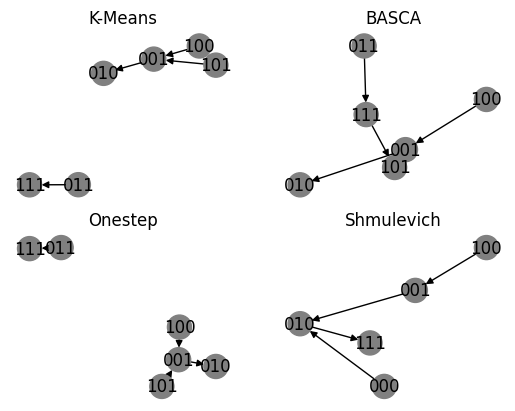

In [6]:
import matplotlib.pyplot as plt

def create_boolean_network_graph(selected):
    
    KMeans = pd.DataFrame(create_boolean_network(selected, "K-Means"))
    BASCA = pd.DataFrame(create_boolean_network(selected, "BASC A"))
    Onestep = pd.DataFrame(create_boolean_network(selected, "Onestep"))
    Shmul = pd.DataFrame(create_boolean_network(selected, "Shmulevich"))
    
    G1 = nx.DiGraph()
    G2 = nx.DiGraph()
    G3 = nx.DiGraph()
    G4 = nx.DiGraph()
    
    for index, row in KMeans.iterrows():
        KMeans_curr_state = str(row["A"]) + str(row["B"]) + str(row["C"])
        KMeans_next_state = str(row["A'"]) + str(row["B'"]) + str(row["C'"])
        
        BASC_curr_state = str(BASCA.at[index ,"A"]) + str(BASCA.at[index, "B"]) + str(BASCA.at[index, "C"])
        BASC_next_state = str(BASCA.at[index ,"A'"]) + str(BASCA.at[index, "B'"]) + str(BASCA.at[index, "C'"])
        
        One_curr_state = str(Onestep.at[index ,"A"]) + str(Onestep.at[index, "B"]) + str(Onestep.at[index, "C"])
        One_next_state = str(Onestep.at[index ,"A'"]) + str(Onestep.at[index, "B'"]) + str(Onestep.at[index, "C'"])
        
        Shm_curr_state = str(Shmul.at[index ,"A"]) + str(Shmul.at[index, "B"]) + str(Shmul.at[index, "C"])
        Shm_next_state = str(Shmul.at[index ,"A'"]) + str(Shmul.at[index, "B'"]) + str(Shmul.at[index, "C'"])
        
        '''if(KMeans_curr_state == BASC_curr_state == One_curr_state == Shm_curr_state):
            
            G1.add_node(KMeans_curr_state, color = 'gray')

            G2.add_node(BASC_curr_state, color = 'gray')

            G3.add_node(One_curr_state, color = 'gray')

            G4.add_node(Shm_curr_state, color = 'gray')
            
        else:
            
            G1.add_node(KMeans_curr_state, color = 'red')

            G2.add_node(BASC_curr_state, color = 'red')

            G3.add_node(One_curr_state, color = 'red')

            G4.add_node(Shm_curr_state, color = 'red')
            
        if(KMeans_next_state == BASC_next_state == One_next_state == Shm_next_state):
            
            G1.add_node(KMeans_next_state, color = 'gray')

            G2.add_node(BASC_next_state, color = 'gray')
            
            G3.add_node(One_next_state, color = 'gray')

            G4.add_node(Shm_next_state, color = 'gray')
            
        else:
            
            G1.add_node(KMeans_next_state, color = 'red')

            G2.add_node(BASC_next_state, color = 'red')

            G3.add_node(One_next_state, color = 'red')

            G4.add_node(Shm_next_state, color = 'red')'''
        
        G1.add_node(KMeans_curr_state, color = 'gray')
        G2.add_node(BASC_curr_state, color = 'gray')
        G3.add_node(One_curr_state, color = 'gray')
        G4.add_node(Shm_curr_state, color = 'gray')
        
        G1.add_node(KMeans_next_state, color = 'gray')
        G2.add_node(BASC_next_state, color = 'gray')   
        G3.add_node(One_next_state, color = 'gray')
        G4.add_node(Shm_next_state, color = 'gray')
            
        G1.add_edge(KMeans_curr_state, KMeans_next_state)
        G2.add_edge(BASC_curr_state, BASC_next_state)
        G3.add_edge(One_curr_state, One_next_state)
        G4.add_edge(Shm_curr_state, Shm_next_state)
        
    #plt.figure()
    
    pos = nx.spring_layout(G1) 
    plt.subplot(221)
    plt.title("K-Means")
    nx.draw(G1, pos, with_labels=True, node_color=[G1.nodes[n]['color'] for n in G1.nodes])
    #plt.show()
    
    #plt.figure()
    
    plt.subplot(222)
    plt.title("BASCA")
    pos = nx.spring_layout(G2) 
    nx.draw(G2, pos, with_labels=True, node_color=[G2.nodes[n]['color'] for n in G2.nodes])
    #plt.show()
    
    #plt.figure()
    
    plt.subplot(223)
    plt.title("Onestep")
    pos = nx.spring_layout(G3) 
    nx.draw(G3, pos, with_labels=True, node_color=[G3.nodes[n]['color'] for n in G3.nodes])
    #plt.show()
    
    #plt.figure()
    
    plt.subplot(224)
    plt.title("Shmulevich")
    pos = nx.spring_layout(G4) 
    nx.draw(G4, pos, with_labels=True, node_color=[G4.nodes[n]['color'] for n in G4.nodes])
    plt.show()
    
selected = [2, 3, 5]

create_boolean_network_graph(selected)

# Code for 3 interpolations 

In [7]:
def three_interpolation(vect, method):
    thr = []
    n = (len(vect) - 1)
    newSize = len(vect) + (len(vect) - 1)
    gene = vect
    sample = []
    for i in range(3):
        sample.append(newSize)
        indices = np.arange(len(gene))

        interpolated_values = np.interp(
            np.linspace(0, len(gene) - 1, len(gene) + n),
            indices,
            gene
        )
        
        #print(interpolated_values, "\n")
        
        gene = interpolated_values
        
        if(method == 'K-Means'):
            thr.append(K_Means(gene))
        elif(method == 'BASC A'):
            t, _ = BASC_A(gene)
            thr.append(t)
        elif(method == 'Onestep'):
            thr.append(onestep(gene))
        else:
            thr.append(shmulevich(gene))
        
        n = newSize - 1
        newSize = newSize + (newSize-1)
    
    return thr, sample

# Graph One network with rules

In [8]:
def graph_network(rules, label):
    
    G = nx.DiGraph()
    
    for index, row in rules.iterrows():
        curr_state = str(row["A"]) + str(row["B"]) + str(row["C"])
        next_state = str(row["A'"]) + str(row["B'"]) + str(row["C'"])
        
        G.add_node(curr_state)
        G.add_node(next_state)
        G.add_edge(curr_state, next_state)
    
    fig, ax = plt.subplots()
    pos = nx.spring_layout(G)
    ax.set_title("Interpolation of Size " + str(label))
    nx.draw(G, pos, with_labels=True, ax=ax)
    return fig

# Plot the network of the three interpolation

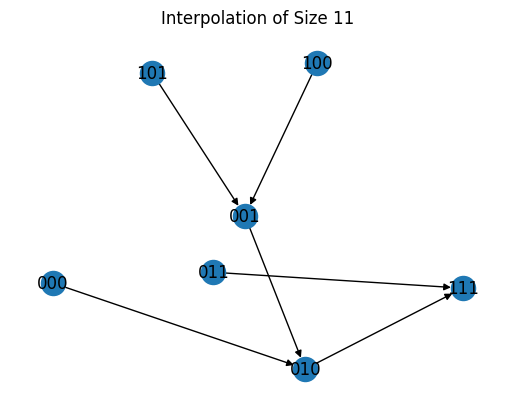

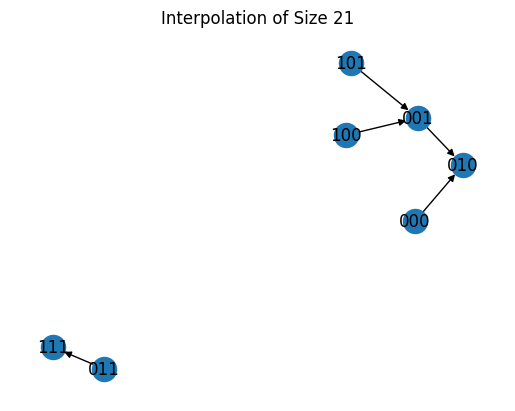

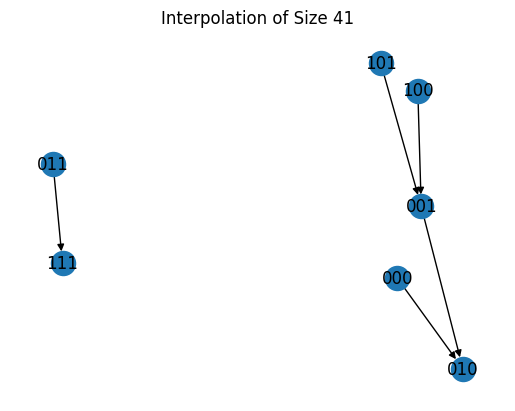

In [9]:
def graph_three_interpolation_network(selected, method):
    
    inter1Net = pd.DataFrame(columns=['A', 'B', 'C', "A'", "B'", "C'"])
    inter2Net = pd.DataFrame(columns=['A', 'B', 'C', "A'", "B'", "C'"])
    inter3Net = pd.DataFrame(columns=['A', 'B', 'C', "A'", "B'", "C'"])
    
    genes = gene_data.iloc[selected].values.astype(float)
    
    thr_arr_geneA = three_interpolation(genes[0], method)
    thr_arr_geneB = three_interpolation(genes[1], method)
    thr_arr_geneC = three_interpolation(genes[2], method)
    
    #print(thr_arr_geneA, thr_arr_geneB, thr_arr_geneC  )
    
    interA_Binarized = []
    interB_Binarized = []
    interC_Binarized = []
    
    binarized1 = []
    binarized2 = []
    binarized3 = []
    
    #print(genes[0], genes[1], genes[2])
    
    for i in range(3):
        
        for j in range(len(genes[0])):
            if(genes[0][j] <= thr_arr_geneA[0][i]):
                binarized1.append(0)
            else:
                binarized1.append(1)
                
            if(genes[1][j] <= thr_arr_geneB[0][i]):
                binarized2.append(0)
            else:
                binarized2.append(1)
                
            if(genes[2][j] <= thr_arr_geneC[0][i]):
                binarized3.append(0)
            else:
                binarized3.append(1)
                
        interA_Binarized.append(binarized1)
        interB_Binarized.append(binarized2)
        interC_Binarized.append(binarized3)
        
        binarized1 = []
        binarized2 = []
        binarized3 = []
                
    inter1Net["A"] = interA_Binarized[0]
    inter1Net["B"] = interB_Binarized[0]
    inter1Net["C"] = interC_Binarized[0]
    
    inter2Net["A"] = interA_Binarized[1]
    inter2Net["B"] = interB_Binarized[1]
    inter2Net["C"] = interC_Binarized[1]
    
    inter3Net["A"] = interA_Binarized[2]
    inter3Net["B"] = interB_Binarized[2]
    inter3Net["C"] = interC_Binarized[2]
    
    #print(interA_Binarized)
    
    #print(inter1Net)
    #print(inter2Net)
    #print(inter3Net)
    
    result = inter1Net[['A', 'B', 'C']]
    
    for index, row in result.iterrows():
        state1 = [row['A'], row['B'], row['C']]
        state2 = [inter2Net.at[index, 'A'], inter2Net.at[index, 'B'], inter2Net.at[index, 'C']]
        state3 = [inter3Net.at[index, 'A'], inter3Net.at[index, 'B'], inter3Net.at[index, 'C']]
        
        inter1Net.at[index, "A'"] = A(state1)
        inter1Net.at[index, "B'"] = B(state1)
        inter1Net.at[index, "C'"] = C(state1)
        
        inter2Net.at[index, "A'"] = A(state2)
        inter2Net.at[index, "B'"] = B(state2)
        inter2Net.at[index, "C'"] = C(state2)
        
        inter3Net.at[index, "A'"] = A(state3)
        inter3Net.at[index, "B'"] = B(state3)
        inter3Net.at[index, "C'"] = C(state3)
        
    #print(inter1Net)
    #print(inter2Net)
    #print(inter3Net)
    
    plot1 = graph_network(inter1Net, thr_arr_geneA[1][0])
    plot2 = graph_network(inter2Net, thr_arr_geneA[1][1])
    plot3 = graph_network(inter3Net, thr_arr_geneA[1][2])

selected = [2, 3, 5]

graph_three_interpolation_network(selected, "Shmulevich")